In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
import io
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import f1_score

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import Compose, Lambda, ToTensor, Normalize, Resize, RandomCrop, TenCrop, RandomHorizontalFlip

2024-02-11 11:49:54.636564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 11:49:54.636672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 11:49:54.801980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Some settings:
# --------------
train_files = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/train/*.tfrec'
valid_files = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/*.tfrec'
test_files  = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/test/*.tfrec'
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # hardware
n_epochs    = 10                                                            # number of training epochs
batch_size  = 20                                                           # training batch size
num_prints  = 10                                                            # number of losses to print per epoch
train_size  = 12753                                                        # number of training data samples
print_freq  = train_size // (batch_size * num_prints) + 1                  # print if iteration is a multiple of this
check_freq  = 1                                                            # save model if epoch is a multiple of this

In [4]:
# Utility functions:
# ------------------

def tfrecords_to_dataframe(fp, test = False):
    '''
    Parse data files into rows of a dataframe.
    
    arguments
    ---------
    fp : str
        Data files pattern.
        
    test : bool
        If true, data files correspond to testing data.
    '''
    def parse(pb, test = False):
        d = {'id': tf.io.FixedLenFeature([], tf.string), 'image': tf.io.FixedLenFeature([], tf.string)}
        if not test:
            d['class'] = tf.io.FixedLenFeature([], tf.int64)
        return tf.io.parse_single_example(pb, d)

    df = {'id': [], 'img': []} 
    if not test:
        df['lab'] = []
    for sample in tf.data.TFRecordDataset(glob.glob(fp)).map(lambda pb: parse(pb, test)):
        df['id'].append(sample['id'].numpy().decode('utf-8'))
        df['img'].append(sample['image'].numpy())
        if not test:
            df['lab'].append(sample['class'].numpy())
    return pd.DataFrame(df)

# ------------------------------------------------------------------------------------------------------------------------

def display_images(dataset, n, cols):
    '''
    Display a grid of labelled images of flowers.
    
    arguments
    ---------
    dataset : Dataset
        Dataset containing the flower images and labels.
        
    n : int
        Number of images to display.
        
    cols : int
        Number of columns in the grid.
    '''
    rows = n // cols if n % cols == 0 else n // cols + 1
    plt.figure(figsize = (2 * cols, 2 * rows))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img, lab = dataset[i]
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(str(lab))
        plt.axis('off')
    plt.show()

In [5]:
# Classes:
# --------

class Trainset(Dataset):
    '''
    Representation of the training dataset.
    '''
    def __init__(self, frac = 1):
        '''
        arguments
        ---------
        frac : float
            Fraction of data samples to keep.
            
            For example, if frac = 0.5, then a random sample of 50% 
            of the data is kept and the remaining 50% is discarded.
        '''
        super().__init__()
        self.df = tfrecords_to_dataframe(train_files).sample(frac = frac).reset_index(drop = True)
        self.t1 = Lambda(lambda b: Image.open(io.BytesIO(b)))
        self.t2 = Compose([RandomCrop(300), 
                           RandomHorizontalFlip(), 
                           ToTensor(), 
                           Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        transform = Compose([self.t1, Resize(np.random.randint(300, 641)), self.t2])
        sample = self.df.iloc[i]
        return transform(sample['img']), sample['lab']

# -------------------------------------------------------------------------------------------------------------------------    

class Evalset(Dataset):
    '''
    Representation of the evaluation datasets.
    '''
    def __init__(self, frac = 1, test = False):
        '''
        arguments
        ---------
        frac : float
            Fraction of data samples to keep.
            
            For example, if frac = 0.5, then a random sample of 50% 
            of the data is kept and the remaining 50% is discarded.
            
        test : bool
            If true, this dataset contains the testing data. 
            Otherwise, this dataset contains the validation data. 
        '''
        super().__init__()
        files = valid_files if not test else test_files
        self.df = tfrecords_to_dataframe(files, test).sample(frac = frac).reset_index(drop = True)
        self.transforms = [Compose([Lambda(lambda b: Image.open(io.BytesIO(b))), 
                                    Resize(scale), 
                                    TenCrop(300), 
                                    Lambda(lambda xs: torch.stack([ToTensor()(x) for x in xs])), 
                                    Lambda(lambda xs: torch.stack([Normalize([0.485, 0.456, 0.406], 
                                                                             [0.229, 0.224, 0.225])(x) for x in xs]))])
                           for scale in [372, 568]]
        self.test = test
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        sample = self.df.iloc[i]
        imgs = torch.stack([t(sample['img']) for t in self.transforms])
        return imgs, sample['lab'] if not self.test else sample['id']

# -------------------------------------------------------------------------------------------------------------------------    

class EfficientNetB0(nn.Module):
    '''
    EfficientNet B0 fine-tune.
    '''
    def __init__(self, n_classes, learnable_modules = ('classifier.1',)):
        '''
        arguments
        ---------
        n_classes : int
            Number of classification categories.
            
        learnable_modules : tuple
            Names of the modules to fine-tune.
        '''
        super().__init__()
        self.efficientnet_b0 = models.efficientnet_b0(weights = 'DEFAULT')
        self.efficientnet_b0.classifier[1] = nn.Linear(self.efficientnet_b0.classifier[1].in_features, n_classes)
        self.efficientnet_b0.requires_grad_(False)
        modules = dict(self.efficientnet_b0.named_modules())
        for name in learnable_modules:
            modules[name].requires_grad_(True)
        
    def forward(self, x):
        return F.log_softmax(self.efficientnet_b0(x), dim = 1)

In [6]:
# Training, validation, and testing data:
# ---------------------------------------
train_set    = Trainset()
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
valid_loader = DataLoader(Evalset(frac = 0.20), batch_size = 1, num_workers = 2)
test_loader  = DataLoader(Evalset(test = True), batch_size = 1, num_workers = 2)

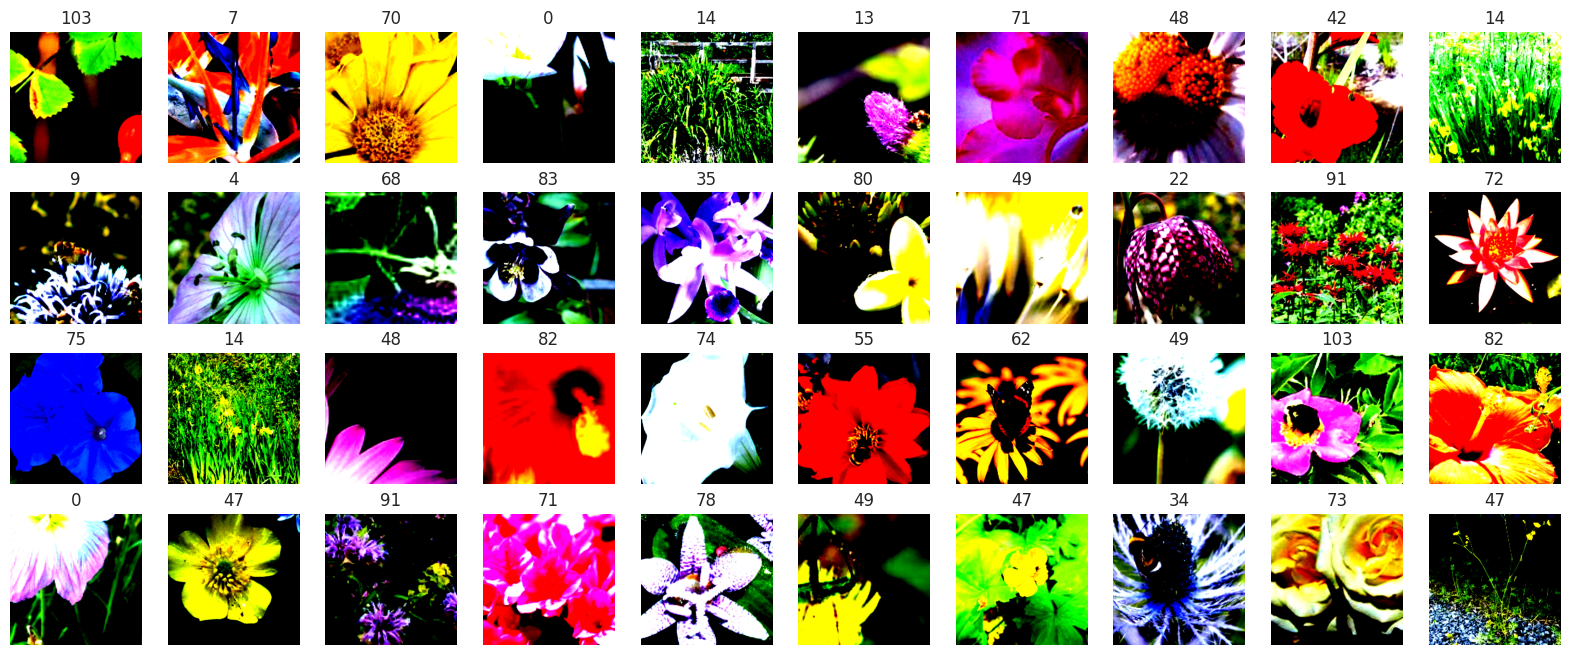

In [7]:
# Display some training images and labels:
# ----------------------------------------
display_images(train_set, n = 40, cols = 10)

In [8]:
# Modelling components:
# ---------------------
model = nn.DataParallel(EfficientNetB0(n_classes = 104, learnable_modules = ('features.5.2', 
                                                                             'features.6', 
                                                                             'features.7', 
                                                                             'features.8', 
                                                                             'classifier')))
model.to(device)

optimizer = torch.optim.Adam(params = [{'params': model.module.efficientnet_b0.features[5][2].parameters()}, 
                                       {'params': model.module.efficientnet_b0.features[6].parameters()}, 
                                       {'params': model.module.efficientnet_b0.features[7].parameters()},
                                       {'params': model.module.efficientnet_b0.features[8].parameters()},
                                       {'params': model.module.efficientnet_b0.classifier.parameters(), 'lr': 1e-3}], 
                             lr = 1e-4, 
                             weight_decay = 1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max = n_epochs)

loss_fn = F.nll_loss

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 27.0MB/s]


In [9]:
# Training loop:
# --------------
losses = []                                                               
valid_f1s = []                                                            
for epoch in range(n_epochs):
    print()
    print(f'Epoch {epoch}:')
    print('-' * len(f'Epoch {epoch}:'))
    model.train() 
    for i, (x, y) in enumerate(train_loader):
        loss = loss_fn(model(x.to(device)), y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % print_freq == 0:
            print('Loss {}: {:.3f}'.format(i, loss.item()))
            losses.append(loss.item())
    if epoch % check_freq == 0:
        model.eval()
        valid_true_labs = []
        valid_pred_labs = []
        with torch.no_grad():
            for x, y in valid_loader:
                valid_true_labs.append(y.item())
                mean_logp = model(x.view(-1, 3, 300, 300).to(device)).mean(dim = 0)
                valid_pred_labs.append(torch.argmax(mean_logp).item())
        valid_f1 = f1_score(valid_true_labs, valid_pred_labs, average = 'weighted')
        valid_f1s.append(valid_f1)
        print()
        print('Validation F1: {:.2f}%'.format(valid_f1 * 100))
        torch.save(model.state_dict(), f'./epoch{epoch // check_freq}.pth')
    scheduler.step()


Epoch 0:
--------
Loss 0: 4.597
Loss 64: 3.407
Loss 128: 2.411
Loss 192: 2.417
Loss 256: 2.311
Loss 320: 1.251
Loss 384: 1.674
Loss 448: 1.373
Loss 512: 1.228
Loss 576: 0.813

Validation F1: 85.23%

Epoch 1:
--------
Loss 0: 0.727
Loss 64: 1.043
Loss 128: 1.115
Loss 192: 1.097
Loss 256: 0.741
Loss 320: 0.830
Loss 384: 0.424
Loss 448: 0.755
Loss 512: 0.891
Loss 576: 0.964

Validation F1: 88.76%

Epoch 2:
--------
Loss 0: 0.687
Loss 64: 0.529
Loss 128: 0.786
Loss 192: 0.781
Loss 256: 0.594
Loss 320: 0.542
Loss 384: 0.712
Loss 448: 0.476
Loss 512: 0.561
Loss 576: 0.433

Validation F1: 91.44%

Epoch 3:
--------
Loss 0: 0.491
Loss 64: 0.262
Loss 128: 0.339
Loss 192: 0.793
Loss 256: 0.463
Loss 320: 0.328
Loss 384: 0.321
Loss 448: 0.383
Loss 512: 0.431
Loss 576: 1.182

Validation F1: 93.41%

Epoch 4:
--------
Loss 0: 0.232
Loss 64: 0.440
Loss 128: 0.624
Loss 192: 0.570
Loss 256: 0.357
Loss 320: 0.367
Loss 384: 0.156
Loss 448: 0.315
Loss 512: 0.368
Loss 576: 0.584

Validation F1: 93.36%

Epoc

In [10]:
optimal_epoch = np.argmax(np.array(valid_f1s)) # highest validation F1 epoch / checkpoint frequency

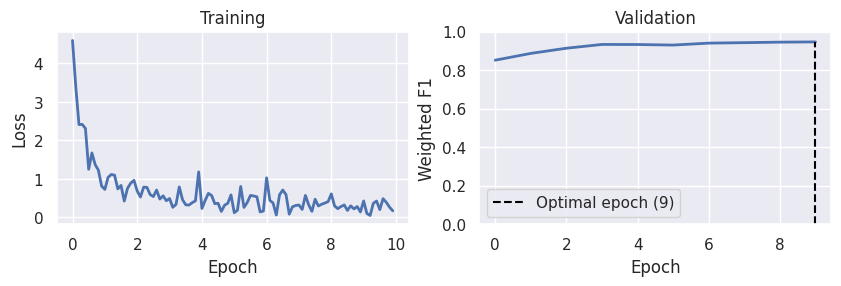

In [11]:
plt.figure(figsize = (10, 2.5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(losses)) / n_epochs, losses, linewidth = 2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training')
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(valid_f1s)) * check_freq, valid_f1s, linewidth = 2)
plt.vlines(optimal_epoch * check_freq, 0, valid_f1s[optimal_epoch], colors = 'black', linestyles = 'dashed', label = f'Optimal epoch ({optimal_epoch * check_freq})')
plt.xlabel('Epoch')
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.title('Validation')
plt.legend(loc = 'lower left')
plt.savefig('plot.png')
plt.show()

In [12]:
# Load the model which achieved the largest validation F1:
# --------------------------------------------------------
model = nn.DataParallel(EfficientNetB0(n_classes = 104, learnable_modules = ())).to(device)
model.load_state_dict(torch.load(f'./epoch{optimal_epoch}.pth'))

<All keys matched successfully>

In [13]:
# Submission:
# -----------
ids = []
preds = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        ids.append(y[0])
        mean_logp = model(x.view(-1, 3, 300, 300).to(device)).mean(dim = 0)
        preds.append(torch.argmax(mean_logp).item())
submission = pd.DataFrame({'id': ids, 'label': preds})
submission.to_csv('submission.csv', index = False)
submission.head()

,id,label
0,ce2745e96,52
1,29d5a8bd5,103
2,d0ee253f0,67
3,4d0ffe92c,67
4,ac1156cb1,88
